Qui viene fatta la stessa analisi presente al'interno del notebook 'Dimensionality reduction'. La differenza è che invece di utilizzare la funzione RFECV di sklearn, ne utilizziamo una implementata manualmente, RFE_CV, che permette di ricavare informazioni aggiuntive. L'analisi porta a selezionare 23 attributi.

In [360]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV, SelectKBest, f_classif, mutual_info_classif
import pickle

In [324]:
def eta_squared(X, y):
    if isinstance(X, type(np.array([]))):
        X = pd.DataFrame(X)
    if isinstance(y, type(np.array([]))):
        y = pd.DataFrame(y)    
    df = pd.concat((X, y), axis = 1, ignore_index = True)
    varibles = df.columns[:-1]
    target = df.columns[-1]
    variances = df[varibles].var(ddof = 0)
    means = df[varibles].mean()
    g = df.groupby(target)
    g_sizes = g.size()
    g_means = g.mean()
    var_g_means = (((g_means - means)**2).mul(g_sizes, axis=0)).sum() / df.shape[0]
    eta = var_g_means / variances
    return eta

def F_test(X, y):
    if isinstance(X, type(np.array([]))):
        X = pd.DataFrame(X)
    if isinstance(y, type(np.array([]))):
        y = pd.DataFrame(y)   
    n_classes = np.unique(y_train).size
    df = pd.concat((X, y), axis = 1, ignore_index = True)
    varibles = df.columns[:-1]
    target = df.columns[-1]
    means = df[varibles].mean()
    g = df.groupby(target)
    g_sizes = g.size()
    g_means = g.mean()
    g_variances = g.var(ddof = 0)
    expl_vars = (((g_means - means) ** 2).mul(g_sizes, axis = 0)).sum() / (n_classes - 1)
    unexpl_vars = ((g_variances.mul(g_sizes, axis = 0)) / (df.shape[0] - n_classes)).sum()
    return expl_vars / unexpl_vars

def variance(X, y):
    '''
    The function computes the variance of each feature of X. 
    y has no purpose in this function. It was included because we needed 
    a 2nd argument to pass the function as an argument of SelectKBest.
    '''
    if isinstance(X, type(np.array([]))):
        X = pd.DataFrame(X) 
    return X.var()

In [369]:
with open("features.txt") as f:
    lines = f.read().splitlines() 

features = {}
for line in lines:
    idx, name = line.split()
    features[int(idx)-1] = name

In [41]:
X_train = pd.read_csv(r'.\old datasets\X_train_wo_outliers_num.csv', header = 0, index_col = 0)
y_train = pd.read_csv('y_train_wo_outliers_num.csv', header = None)[0]

In [42]:
X_train.index = list(range(X_train.shape[0]))

In [119]:
X_test = pd.read_csv(r'.\old datasets\X_test_no_red.csv', header = 0)

In [44]:
fe_imp = DTC().fit(X_train, y_train).feature_importances_
best_features = X_train.columns[fe_imp > 0] 

In [45]:
best_features.size

130

In [301]:
class RFE_CV:
    def __init__(self, clf, embedded_func: '{importances, coefficients}', 
                 scoring = 'accuracy', cv = 5, n_jobs = -1):
        self.scores = []
        self.std_scores = []
        self.estimator = clf
        self._embedded_func = embedded_func
        self.scoring = scoring
        self.cv = cv
        self.n_jobs = n_jobs
        self.n_features = None        
        self.best_score = None
        self.selected_features = None
        # we can use the keys of a dict as an ordered set (python 3.6+)
        self.eliminated_features = {}
        
    def _importances(self, df, cross_val):
        mean_feature_imp = np.zeros_like(df.columns)
        for estimator in cross_val['estimator']:
            mean_feature_imp = mean_feature_imp + estimator.feature_importances_
        mean_feature_imp = mean_feature_imp / self.cv
        return mean_feature_imp
    
    def _coefficients(self, df, cross_val):
        mean_coeff = np.zeros_like(df.columns) 
        for estimator in cross_val['estimator']:
            coeff = np.abs(estimator.coef_).mean(axis = 0).reshape(-1)
            mean_coeff = mean_coeff + coeff
        mean_coeff = mean_coeff / self.cv
        return mean_coeff
    
    def best_n_features(self, n):
        n_to_remove = self.columns.size - n
        to_remove = set(list(self.eliminated_features)[:n_to_remove])
        n_features = np.array([col for col in self.columns if col not in to_remove])        
        score = self.scores[n_to_remove]
        return {'n_features': n_features, 'score': score}
        
    def fit(self, X, y):
        if self._embedded_func == 'importances':
            embedded_func = self._importances
        elif self._embedded_func == 'coefficients':
            embedded_func = self._coefficients
        self.columns = X.columns
        for i in range(X.columns.size):
            cols = [col for col in self.columns if col not in self.eliminated_features]
            df = X[cols]
            cross_val = cross_validate(self.estimator, df, y, scoring = self.scoring, 
                                       cv = self.cv, return_estimator = True, 
                                       n_jobs = self.n_jobs)
            score_arr = cross_val['test_score']
            self.scores.append(score_arr.mean())
            self.std_scores.append(score_arr.std())
            mean_embedded_func = embedded_func(df, cross_val)
            min_pos = np.argmin(mean_embedded_func)
            col_name = df.columns[min_pos]
            self.eliminated_features[col_name] = i # just to put a value  
        pos_max = np.argmax(self.scores)
        self.best_score = self.scores[pos_max]
        self.n_features = X.columns.size - pos_max
        to_remove = set(list(self.eliminated_features)[:pos_max])
        self.selected_features = np.array([col for col in self.columns if col not in to_remove])

In [216]:
model = RFE_CV(DTC(random_state = 1567))
model.fit(X_train[best_features], y_train)

In [217]:
model.best_score

0.8891960086406974

In [221]:
model.n_features

23

In [218]:
selected = model.selected_features.copy().astype(str)

In [219]:
selected

array(['37', '40', '50', '51', '52', '53', '54', '57', '67', '71', '74',
       '76', '129', '132', '159', '209', '302', '393', '448', '450',
       '503', '508', '559'], dtype='<U3')

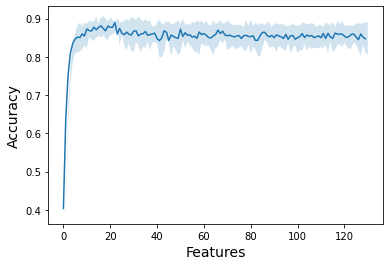

In [226]:
scores = np.array(model.scores[::-1])
std_dev = np.array(model.std_scores[::-1])
plt.plot(range(scores.size), scores)
plt.fill_between(range(1,scores.size+1), scores - std_dev, scores + std_dev, alpha = 0.2)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
#plt.savefig('rfecv_dtc.pdf', bbox_inches = 'tight')
plt.show()

In [361]:
# pickle.dump(selected, open('best_features', 'wb'))

In [367]:
X_train[selected].to_csv('best_X_train.csv', index = False)

In [368]:
X_test[selected].to_csv('best_X_test.csv', index = False)

In [372]:
best_X_train_con_nomi = X_train[selected]
best_X_train_con_nomi.columns = [features[int(col)] for col in selected]
best_X_train_con_nomi.to_csv('best_X_train_con_nomi.csv', index = False)

In [374]:
best_X_test_con_nomi = X_test[selected]
best_X_test_con_nomi.columns = [features[int(col)] for col in selected]
best_X_test_con_nomi.to_csv('best_X_test_con_nomi.csv', index = False)

In [ ]:
X_train.to_csv()

In [178]:
# Logistic Regression

In [302]:
rfecv_logit = RFE_CV(LogisticRegression(random_state = 5, max_iter = 1000),
                    embedded_func = 'coefficients')

In [303]:
rfecv_logit.fit(X_train[best_features], y_train)

In [304]:
rfecv_logit.n_features

64

In [305]:
rfecv_logit.best_score

0.9309907968065344

In [307]:
logit_best_30 = rfecv_logit.best_n_features(30)
logit_best_30['n_features']

array(['4', '9', '37', '40', '49', '50', '52', '53', '54', '57', '67',
       '71', '74', '89', '102', '149', '159', '166', '185', '234', '271',
       '287', '302', '368', '429', '459', '503', '508', '558', '559'],
      dtype='<U3')

In [308]:
logit_best_30['score']

0.9242537944856469

In [359]:
cross_val_score(LogisticRegression(max_iter = 1000), X_train[selected],y_train, 
                cv= 10, scoring = 'accuracy', n_jobs = -1).mean()

0.9063916138881751

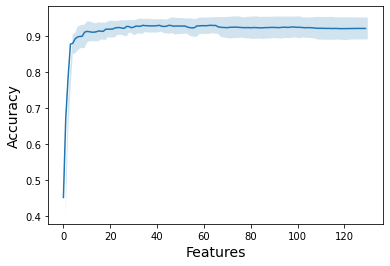

In [286]:
scores = np.array(rfecv_logit.scores[::-1])
std_dev = np.array(rfecv_logit.std_scores[::-1])
plt.plot(range(scores.size), scores)
plt.fill_between(range(1,scores.size+1), scores - std_dev, scores + std_dev, alpha = 0.2)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
#plt.savefig('rfecv_dtc.pdf', bbox_inches = 'tight')
plt.show()

In [48]:
# LinearSVC

In [310]:
rfecv_svc = RFE_CV(LinearSVC(random_state = 5),
                    embedded_func = 'coefficients')

In [311]:
rfecv_svc.fit(X_train[best_features], y_train)

In [312]:
rfecv_svc.n_features

83

In [313]:
rfecv_svc.best_score

0.9271410541839789

In [317]:
rfecv_svc_30 = rfecv_svc.best_n_features(30)
rfecv_svc_30['n_features']

array(['40', '49', '50', '52', '53', '57', '59', '89', '129', '136',
       '166', '168', '176', '234', '239', '271', '302', '332', '347',
       '382', '418', '429', '439', '488', '490', '491', '503', '508',
       '558', '559'], dtype='<U3')

In [318]:
rfecv_svc_30['score']

0.9107810188270772

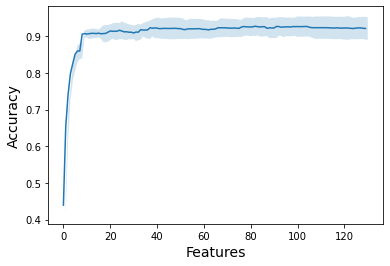

In [316]:
scores = np.array(rfecv_svc.scores[::-1])
std_dev = np.array(rfecv_svc.std_scores[::-1])
plt.plot(range(scores.size), scores)
plt.fill_between(range(1,scores.size+1), scores - std_dev, scores + std_dev, alpha = 0.2)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
#plt.savefig('rfecv_dtc.pdf', bbox_inches = 'tight')
plt.show()

---

La parte sotto è uguale a quella presente nel notebook 'Dimensionality Reduction'. È stata inserita per fare il wrapper approach.

#### Variance Threshold

This method is unsupervised because it does not take into account the target variable. Moreover, it is univariate because it considers just one variable at a time.

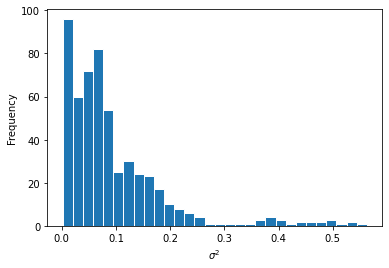

In [321]:
# There are a lot of attributes with very low variance

attr_var = X_train.var()
attr_var.plot.hist(bins = 30, edgecolor = 'w')
plt.xlabel('$\sigma^2$')
plt.show()

In [322]:
# attributes with a var < -0.1

low_var_attr = attr_var[attr_var < 0.1].index
for col in low_var_attr:
    print(features[col])

NameError: name 'features' is not defined

In [323]:
len(low_var_attr)

366

In [36]:
X_train_var_red = X_train[[col for col in features if col not in low_var_attr]]

In [37]:
X_train_var_red.shape

(7274, 174)

#### Eta-squared

The $\eta^2_{X|Y} = \frac{\sigma^2_{\mathrm{Medie}(X|Y)}}{\sigma^2_X}$ statistics can be used to measure the dependence among quantitative and categorical variables. It varies in $[0,1]$ and can be interpreted as the $R^2$ for quantitative variables or as the Cramér's V ($\chi^2$ normalized) for categorical variables.

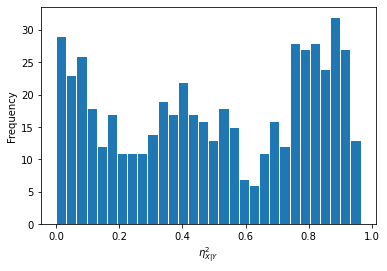

In [325]:
eta = eta_squared(X_train,y_train)
eta.plot.hist(bins = 30, edgecolor = 'w')
plt.xlabel('$\eta^2_{X|Y}$')
plt.show()

In [39]:
low_eta_attr = eta[eta < 0.5].index
for col in low_eta_attr:
    print(features[col])

tBodyAcc-mean()-X
tBodyAcc-mean()-Y
tBodyAcc-mean()-Z
tBodyAcc-arCoeff()-X,2
tBodyAcc-arCoeff()-X,3
tBodyAcc-arCoeff()-X,4
tBodyAcc-arCoeff()-Y,1
tBodyAcc-arCoeff()-Y,2
tBodyAcc-arCoeff()-Y,3
tBodyAcc-arCoeff()-Y,4
tBodyAcc-arCoeff()-Z,1
tBodyAcc-arCoeff()-Z,2
tBodyAcc-arCoeff()-Z,3
tBodyAcc-arCoeff()-Z,4
tBodyAcc-correlation()-X,Y
tBodyAcc-correlation()-X,Z
tBodyAcc-correlation()-Y,Z
tGravityAcc-std()-X
tGravityAcc-std()-Y
tGravityAcc-std()-Z
tGravityAcc-mad()-X
tGravityAcc-mad()-Y
tGravityAcc-mad()-Z
tGravityAcc-sma()
tGravityAcc-iqr()-X
tGravityAcc-iqr()-Y
tGravityAcc-iqr()-Z
tGravityAcc-entropy()-X
tGravityAcc-entropy()-Y
tGravityAcc-entropy()-Z
tGravityAcc-arCoeff()-X,1
tGravityAcc-arCoeff()-X,2
tGravityAcc-arCoeff()-X,3
tGravityAcc-arCoeff()-X,4
tGravityAcc-arCoeff()-Y,1
tGravityAcc-arCoeff()-Y,2
tGravityAcc-arCoeff()-Y,3
tGravityAcc-arCoeff()-Y,4
tGravityAcc-arCoeff()-Z,1
tGravityAcc-arCoeff()-Z,2
tGravityAcc-arCoeff()-Z,3
tGravityAcc-arCoeff()-Z,4
tGravityAcc-correlation()-X,Y


KeyError: 220

In [40]:
len(low_eta_attr)

270

In [41]:
X_train_eta_red = X_train[[col for col in features if col not in low_eta_attr]]

In [42]:
X_train_eta_red.shape

(7274, 279)

#### F-test

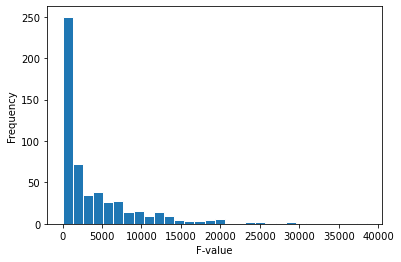

In [326]:
attr_F = F_test(X_train,y_train)
attr_F.plot.hist(bins = 30, edgecolor = 'w')
plt.xlabel('F-value')
plt.show()

In [44]:
attr_F.sort_values()

82         0.316246
80         0.475695
81         0.698710
534        1.057578
162        1.967953
           ...     
52     28173.296697
49     28343.715773
40     29450.369627
350    29649.266509
349    38558.975246
Length: 540, dtype: float64

In [45]:
low_F_attr = attr_F[attr_F < 1000].index
for col in low_F_attr:
    print(features[col])

tBodyAcc-mean()-X
tBodyAcc-mean()-Y
tBodyAcc-mean()-Z
tBodyAcc-arCoeff()-X,2
tBodyAcc-arCoeff()-X,3
tBodyAcc-arCoeff()-X,4
tBodyAcc-arCoeff()-Y,1
tBodyAcc-arCoeff()-Y,2
tBodyAcc-arCoeff()-Y,3
tBodyAcc-arCoeff()-Y,4
tBodyAcc-arCoeff()-Z,1
tBodyAcc-arCoeff()-Z,2
tBodyAcc-arCoeff()-Z,3
tBodyAcc-arCoeff()-Z,4
tBodyAcc-correlation()-X,Y
tBodyAcc-correlation()-X,Z
tBodyAcc-correlation()-Y,Z
tGravityAcc-std()-X
tGravityAcc-std()-Y
tGravityAcc-std()-Z
tGravityAcc-mad()-X
tGravityAcc-mad()-Y
tGravityAcc-mad()-Z
tGravityAcc-sma()
tGravityAcc-iqr()-X
tGravityAcc-iqr()-Y
tGravityAcc-iqr()-Z
tGravityAcc-entropy()-X
tGravityAcc-entropy()-Y
tGravityAcc-entropy()-Z
tGravityAcc-arCoeff()-X,1
tGravityAcc-arCoeff()-X,2
tGravityAcc-arCoeff()-X,3
tGravityAcc-arCoeff()-X,4
tGravityAcc-arCoeff()-Y,1
tGravityAcc-arCoeff()-Y,2
tGravityAcc-arCoeff()-Y,3
tGravityAcc-arCoeff()-Y,4
tGravityAcc-arCoeff()-Z,1
tGravityAcc-arCoeff()-Z,2
tGravityAcc-arCoeff()-Z,3
tGravityAcc-arCoeff()-Z,4
tGravityAcc-correlation()-X,Y


KeyError: 220

In [46]:
len(low_F_attr)

221

In [47]:
X_train_F_red = X_train[[col for col in features if col not in low_F_attr]]

In [48]:
X_train_F_red.shape

(7274, 328)

Let's check if the custom function is correct

In [49]:
# best 20 features
sklearn_best = SelectKBest(k=20).fit(X_train, y_train.values.flatten()).get_support(indices=True)
custom_best = attr_F.sort_values(ascending = False)[:20].index

In [50]:
set(sklearn_best) == set(custom_best)

True

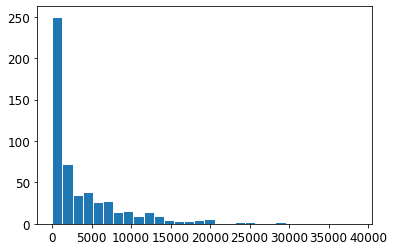

In [51]:
plt.hist(f_classif(X_train, y_train.values.flatten())[0], #tuple: F-values, p_values
         bins = 30, edgecolor = 'w')
plt.show()

#### Mutual Information

It measures the dependency between two variables with the target one discrete (our target variable is discretized). It  measures the reduction in uncertainty for one variable given a known value of the other variable. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

The methods based on F-test estimate the degree of linear dependency between two random variables. On the other hand, mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation. [1][2]

[1] https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

[2] https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#comparison-of-f-test-and-mutual-information

In [327]:
mutual_info = mutual_info_classif(X_train, y_train, discrete_features = False, 
                                  random_state = 5)

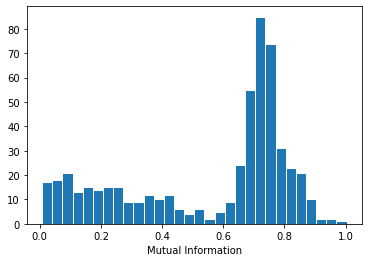

In [328]:
plt.hist(mutual_info, bins = 30, edgecolor = 'w')
plt.xlabel('Mutual Information')
plt.show()

---

Let's now apply the filter strategy

In [54]:
param = {'fs__k': list(range(1, best_features.size + 1))}

In [55]:
# F_test 
# DTC

In [56]:
pipe_dtc = Pipeline([('fs', SelectKBest(score_func = f_classif)), 
                     ('dtc', DTC())])
grid_search_dtc = GridSearchCV(pipe_dtc, param, scoring = 'accuracy', 
                           n_jobs = -1, cv = 5)

In [57]:
grid_search_dtc.fit(X_train[best_features], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fs', SelectKBest()),
                                       ('dtc', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'fs__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                   25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

In [58]:
# best number of features

grid_search_dtc.best_params_

{'fs__k': 58}

The 61 features with the highest F-value produce the best results in terms of accuracy when used with the DTC.

Since we are using stratified cross-validation the results might slightly change at each iteration.

In [59]:
# best accuracy

grid_search_dtc.best_score_

0.8612915668117813

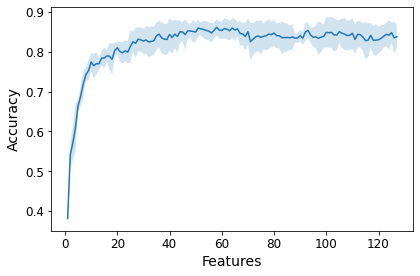

In [60]:
plot_features_cv(grid_search_dtc)

In [61]:
# F_test 
# KNN

In [62]:
pipe_knn = Pipeline([('fs', SelectKBest(score_func = f_classif)),
            ('knn', KNN())])
grid_search_knn = GridSearchCV(pipe_knn, param, scoring = 'accuracy', 
                               n_jobs = -1, cv = 5)

In [63]:
grid_search_knn.fit(X_train[best_features], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fs', SelectKBest()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'fs__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                   25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

In [64]:
# best number of features

grid_search_knn.best_params_

{'fs__k': 124}

Surprisingly the KNN performs better with all the features features

In [65]:
# best accuracy

grid_search_knn.best_score_

0.901157229493706

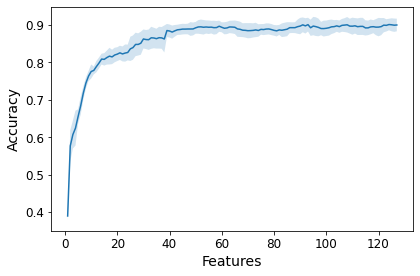

In [66]:
plot_features_cv(grid_search_knn)

However, can be seen that after 45/50 features the funtion is steady. Therefore, we could select the best 45/50 features. 

---

In [67]:
# MI 
# DTC

In [68]:
pipe_dtc_mi = Pipeline([('fs', SelectKBest(score_func = mutual_info_classif)), 
                     ('dtc', DTC())])
grid_search_dtc_mi = GridSearchCV(pipe_dtc_mi, param, scoring = 'accuracy', 
                           n_jobs = -1, cv = 5)

In [69]:
grid_search_dtc_mi.fit(X_train[best_features], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fs',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x00000205FE87D040>)),
                                       ('dtc', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'fs__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                   25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

In [70]:
# best number of features

grid_search_dtc_mi.best_params_

{'fs__k': 46}

In [71]:
# best accuracy

grid_search_dtc_mi.best_score_

0.8563418842203283

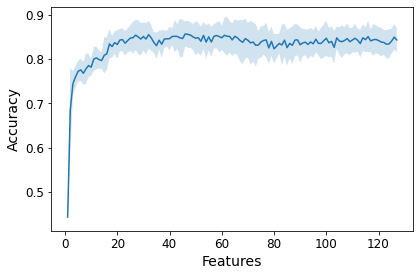

In [72]:
plot_features_cv(grid_search_dtc_mi)

In [73]:
# MI 
# KNN

In [74]:
pipe_knn_mi = Pipeline([('fs', SelectKBest(score_func = mutual_info_classif)),
                     ('knn', KNN())])
grid_search_knn_mi = GridSearchCV(pipe_knn_mi, param, scoring = 'accuracy', 
                               n_jobs = -1, cv = 5)

In [75]:
grid_search_knn_mi.fit(X_train[best_features], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fs',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x00000205FE87D040>)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'fs__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                   25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

In [76]:
# best number of features

grid_search_knn_mi.best_params_

{'fs__k': 91}

In [77]:
# best accuracy

grid_search_knn_mi.best_score_

0.902121319549814

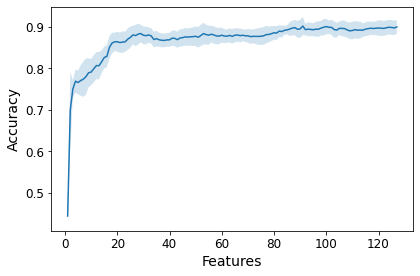

In [78]:
plot_features_cv(grid_search_knn_mi)

In [79]:
# ETA
# DTC

In [80]:
pipe_dtc_eta = Pipeline([('fs', SelectKBest(score_func = eta_squared)), 
                     ('dtc', DTC())])
grid_search_dtc_eta = GridSearchCV(pipe_dtc_eta, param, scoring = 'accuracy', 
                           n_jobs = -1, cv = 5)

In [81]:
grid_search_dtc_eta.fit(X_train[best_features], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fs',
                                        SelectKBest(score_func=<function eta_squared at 0x00000205FE8F9310>)),
                                       ('dtc', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'fs__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                   25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

In [82]:
# best number of features

grid_search_dtc_eta.best_params_

{'fs__k': 60}

In [83]:
# best accuracy

grid_search_dtc_eta.best_score_

0.8670651408367485

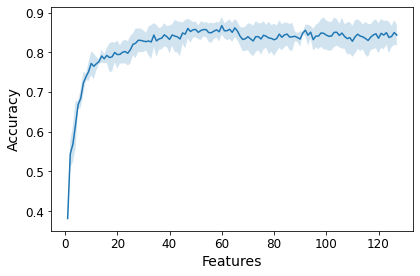

In [84]:
plot_features_cv(grid_search_dtc_eta)

In [85]:
# ETA
# KNN

In [86]:
pipe_knn_eta = Pipeline([('fs', SelectKBest(score_func = eta_squared)), 
                     ('dtc', KNN())])
grid_search_knn_eta = GridSearchCV(pipe_knn_eta, param, scoring = 'accuracy', 
                           n_jobs = -1, cv = 5)

In [87]:
grid_search_knn_eta.fit(X_train[best_features], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fs',
                                        SelectKBest(score_func=<function eta_squared at 0x00000205FE8F9310>)),
                                       ('dtc', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'fs__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                   25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

In [88]:
# best number of features

grid_search_knn_eta.best_params_

{'fs__k': 124}

In [89]:
# best accuracy

grid_search_knn_eta.best_score_

0.901157229493706

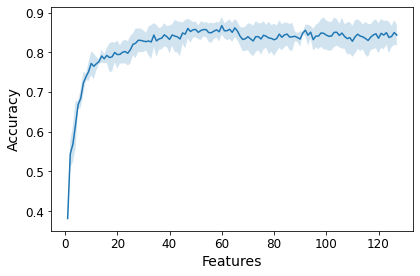

In [90]:
plot_features_cv(grid_search_dtc_eta)

---

In [91]:
# Variance
# DTC

Unlike the other score functions used so far, the variance does not take into account information about labels, thus it is an unsupervised method.

In [92]:
pipe_dtc_var = Pipeline([('fs', SelectKBest(score_func = variance)), 
                     ('dtc', DTC())])
grid_search_dtc_var = GridSearchCV(pipe_dtc_var, param, scoring = 'accuracy', 
                           n_jobs = -1, cv = 5)

In [93]:
grid_search_dtc_var.fit(X_train[best_features], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fs',
                                        SelectKBest(score_func=<function variance at 0x00000205FE8EF310>)),
                                       ('dtc', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'fs__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                   25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

In [94]:
# best number of features

grid_search_dtc_var.best_params_

{'fs__k': 56}

In [95]:
# best accuracy

grid_search_dtc_var.best_score_

0.8601921940659019

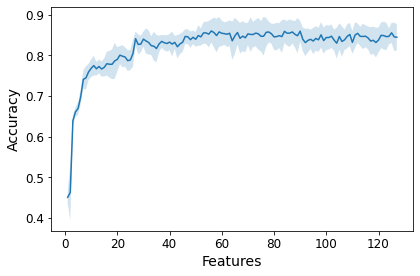

In [96]:
plot_features_cv(grid_search_dtc_var)

In [97]:
# Variance
# KNN

In [98]:
pipe_knn_var = Pipeline([('fs', SelectKBest(score_func = variance)), 
                     ('dtc', KNN())])
grid_search_knn_var = GridSearchCV(pipe_knn_var, param, scoring = 'accuracy', 
                           n_jobs = -1, cv = 5)

In [99]:
grid_search_knn_var.fit(X_train[best_features], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fs',
                                        SelectKBest(score_func=<function variance at 0x00000205FE8EF310>)),
                                       ('dtc', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'fs__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                   25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

In [100]:
# best number of features

grid_search_knn_var.best_params_

{'fs__k': 103}

In [101]:
# best accuracy

grid_search_knn_var.best_score_

0.9011577967167241

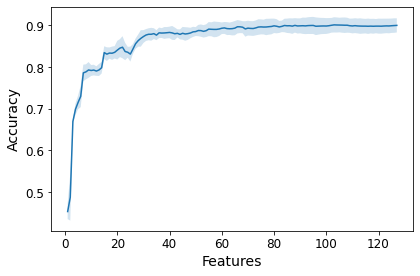

In [102]:
plot_features_cv(grid_search_knn_var)

In [349]:
mi_best_idx = X_train.columns[np.argsort(mutual_info)[::-1]]
f_best_idx = X_train.columns[np.argsort(attr_F)[::-1].values]
eta_best_idx = X_train.columns[np.argsort(eta)[::-1].values]
var_best_idx = X_train.columns[np.argsort(attr_var)[::-1].values]

In [350]:
filter_best_attr = [mi_best_idx, eta_best_idx, f_best_idx, var_best_idx, logit_best_30['n_features'], rfecv_svc_30['n_features']]
# join the arrays preserving the order and removing duplicates
filter_best_attr = dict.fromkeys(np.concatenate(filter_best_attr))
print(len(filter_best_attr))
ensamble_features = set(selected)
for attr in ensamble_features:
    if attr in filter_best_attr:
        del filter_best_attr[attr]
        
max_accuracy = model.best_score #rfecv_dtc.cv_results_['mean_test_score'].max()
new_features = []
while filter_best_attr:
    added_features = set()
    n_added = 0
    for attr in filter_best_attr:        
        temp_features = ensamble_features.copy()
        if attr in temp_features: continue
        else:
            temp_features.add(attr)
            cls = DTC(random_state = 5)
            scores = cross_val_score(cls, X_train[list(temp_features)], y_train, 
                                 cv = 5, n_jobs = -1)
            mean_score = scores.mean()
            if mean_score > max_accuracy:
                ensamble_features.add(attr)
                added_features.add(attr)
                new_features.append(attr)
                n_added += 1
                max_accuracy = mean_score
    print(n_added)
    if not added_features:
        break
    for attr in added_features:
        del filter_best_attr[attr]

540
0


In [117]:
max_accuracy

0.872149538894955

In [152]:
# added features 

for attr in new_features:
    print(features[attr])
print(new_features)

[]


In [153]:
increment = max_accuracy - rfecv_dtc.cv_results_['mean_test_score'].max()
print(f'{increment:.2%}')

0.00%
